In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train-1.csv')
test = pd.read_csv('test.csv')

In [4]:
train.shape

(7352, 563)

In [5]:
test.shape

(2947, 563)

In [6]:
train.isnull().sum().sum()

0

In [7]:
test.isnull().sum().sum()

0

In [8]:
train.duplicated().sum()

0

In [9]:
test.duplicated().sum()

0

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'STANDING'),
  Text(1, 0, 'SITTING'),
  Text(2, 0, 'LAYING'),
  Text(3, 0, 'WALKING'),
  Text(4, 0, 'WALKING_DOWNSTAIRS'),
  Text(5, 0, 'WALKING_UPSTAIRS')])

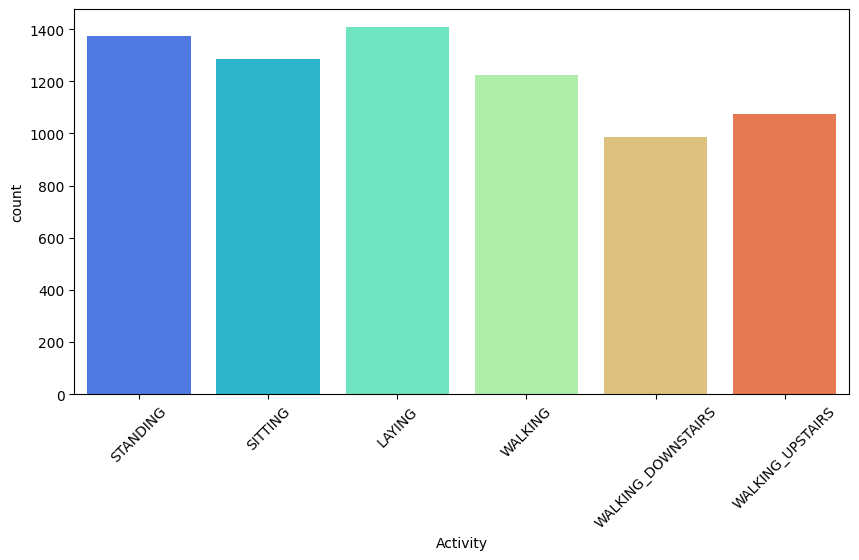

In [10]:
#checking class imbalance 
plt.figure(figsize=(10,5))
sns.countplot(data=train,x='Activity',palette='rainbow')
plt.xticks(rotation = 45)

In [11]:
# EDA 
#to visualize the "Static vs. Dynamic" separation 


<Axes: xlabel='Activity', ylabel='tBodyAccMag-mean()'>

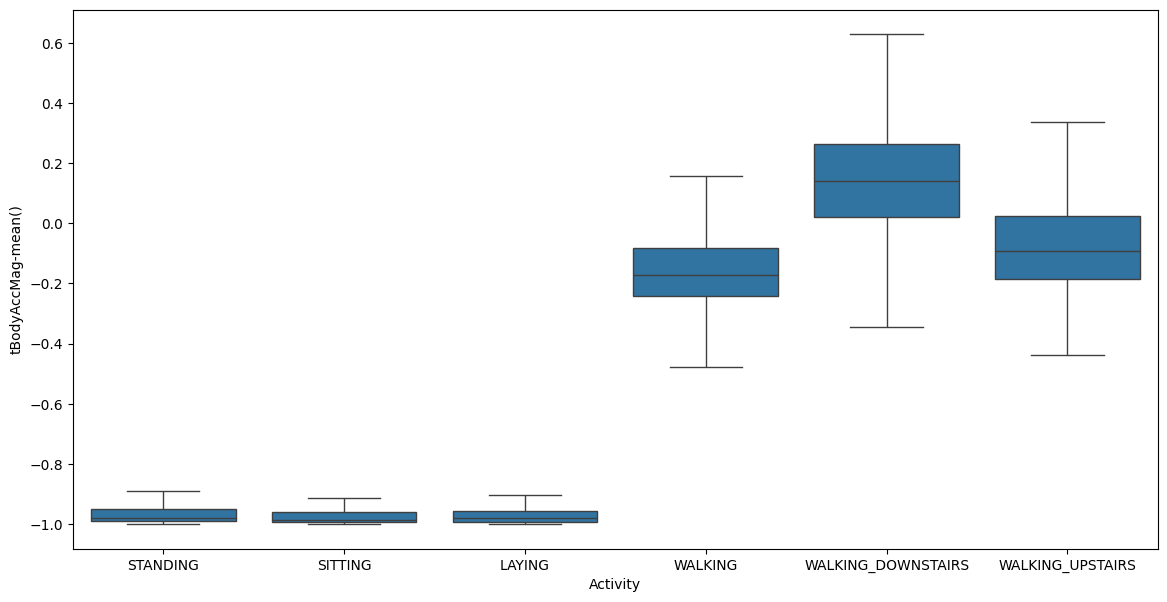

In [13]:
vis_data = train.copy()
#Feature Separability: Boxplots 
plt.figure(figsize=(14,7))
sns.boxplot(x='Activity',y='tBodyAccMag-mean()',data=vis_data,showfliers=False)


Text(0.5, 1.0, 'Separation between Static and Dynamic Activities')

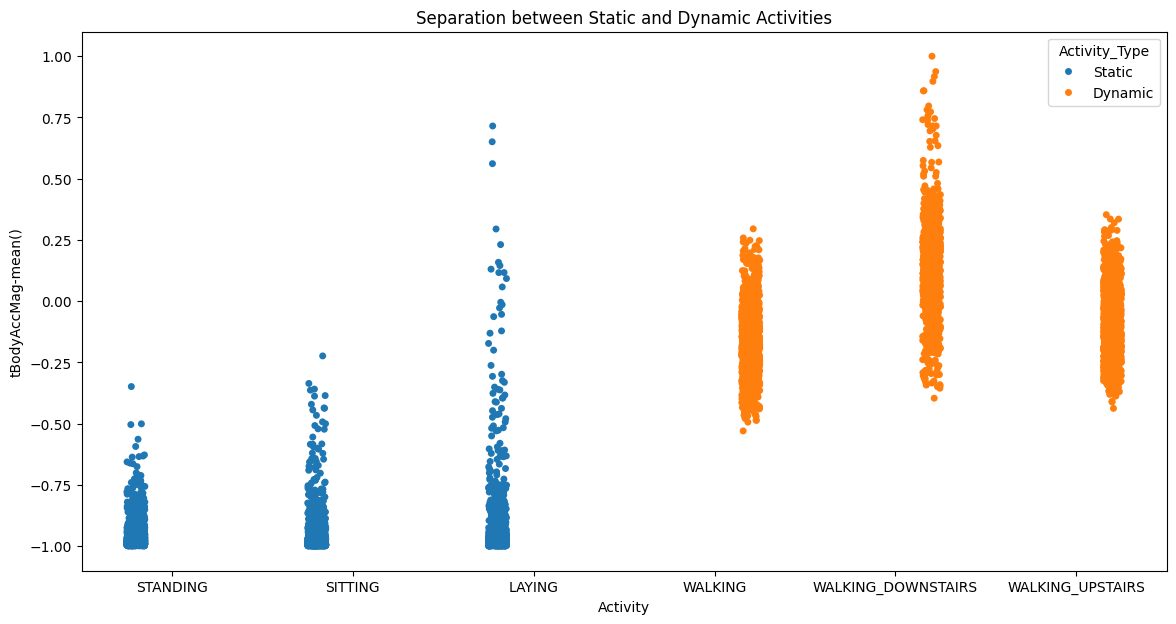

In [15]:
vis_data['Activity_Type'] = vis_data['Activity'].map({
    'STANDING': 'Static', 'SITTING': 'Static', 'LAYING': 'Static',
    'WALKING': 'Dynamic', 'WALKING_DOWNSTAIRS': 'Dynamic', 'WALKING_UPSTAIRS': 'Dynamic'
})
plt.figure(figsize=(14, 7))
sns.stripplot(x='Activity', y='tBodyAccMag-mean()', data=vis_data, jitter=True, hue='Activity_Type', dodge=True)
plt.title("Separation between Static and Dynamic Activities")

In [19]:
# Encoding target variable

from sklearn.preprocessing import LabelEncoder 
le= LabelEncoder() 
# We fit on the whole set of unique labels to ensure consistency
all_labels = pd.concat([train['Activity'],test['Activity']])
le.fit(all_labels)
y_train_enc=le.transform(train['Activity'])
y_test_enc = le.transform(test['Activity'])

X_train = train.drop(['Activity', 'subject'], axis=1) # Dropping subject as it's not a sensor feature
X_test = test.drop(['Activity', 'subject'], axis=1)

In [20]:
X_train.shape

(7352, 561)

In [21]:
y_train_enc.shape

(7352,)

In [22]:
print(le.classes_)

['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [23]:
# Feature Engineering and reduction 
#PCA requires data to be scaled (numbers between -1 and 1) first, or it won't work correctly.

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 


In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Apply PCA
# Instead of picking a random number like 50 components, 
# we tell PCA: "Keep enough components to describe 95% of the variance"

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [27]:
print(f"Original Number of Features: {X_train.shape[1]}")
print(f"Reduced Number of Features: {X_train_pca.shape[1]}")
print(f"Features removed: {X_train.shape[1] - X_train_pca.shape[1]}")

Original Number of Features: 561
Reduced Number of Features: 102
Features removed: 459


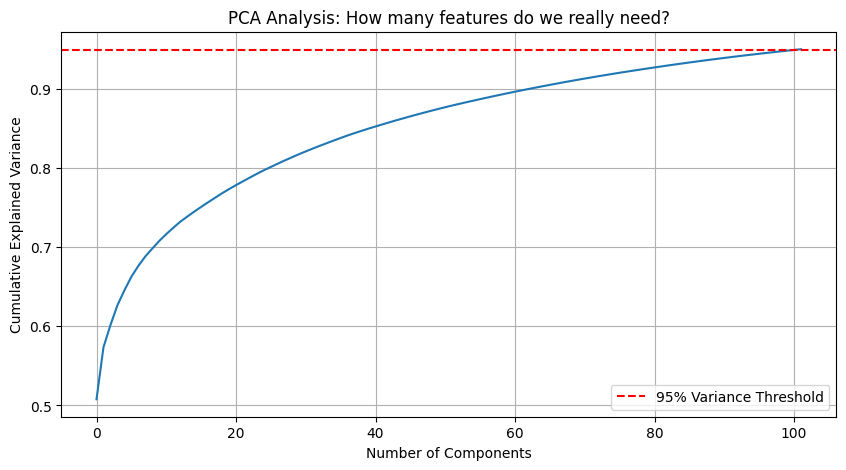

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis: How many features do we really need?')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.show()

# Model Training & Comparison

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

In [31]:
model_results = {} 
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine (SVM)": SVC(kernel='rbf'),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_pca, y_train_enc)
    y_pred = model.predict(X_test_pca)

    acc = accuracy_score(y_test_enc, y_pred)
    model_results[name] = acc
    
    end_time = time.time()
    print(f"{name}: {acc*100:.2f}% Accuracy (Time: {end_time - start_time:.2f}s)")

Logistic Regression: 93.11% Accuracy (Time: 0.70s)
Support Vector Machine (SVM): 93.76% Accuracy (Time: 1.51s)
Random Forest: 87.85% Accuracy (Time: 8.14s)


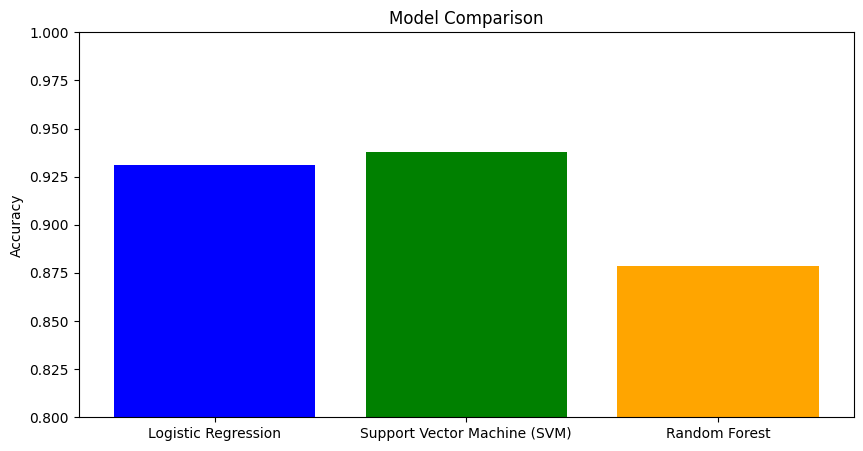

In [34]:
plt.figure(figsize=(10, 5))
plt.bar(model_results.keys(), model_results.values(), color=['blue', 'green', 'orange'])
plt.ylim(0.8, 1.0) # Zoom in to see differences
plt.title("Model Comparison")
plt.ylabel("Accuracy")
plt.show()

# Hyperparameter Tuning (GridSearchCV)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   6.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   6.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   4.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   4.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   3.8s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   2.4s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   2.3s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   2.4s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   1.7s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   1.5s
[CV] END .....................C=0.1, gamma=0.001

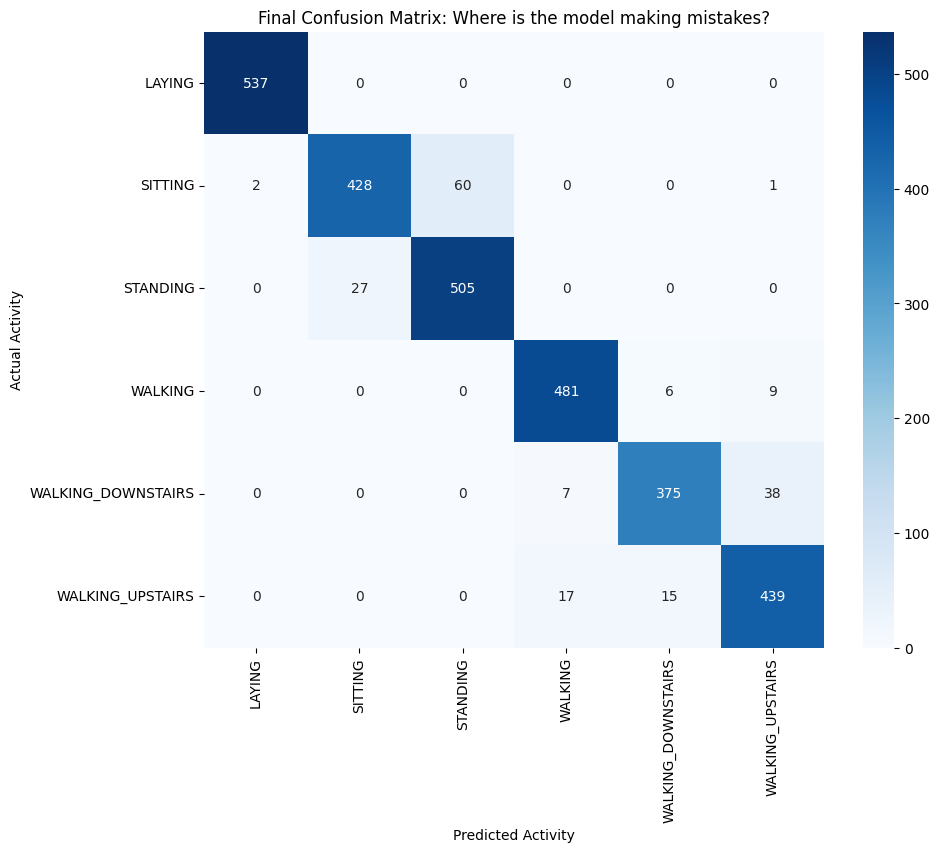

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.94      0.87      0.90       491
          STANDING       0.89      0.95      0.92       532
           WALKING       0.95      0.97      0.96       496
WALKING_DOWNSTAIRS       0.95      0.89      0.92       420
  WALKING_UPSTAIRS       0.90      0.93      0.92       471

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define the Parameter Grid
# C: How strict the margin is (Low = smooth, High = complex)
# Gamma: How far the influence of a single training example reaches
param_grid = {
    'C': [0.1, 1, 10, 100], 
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Run Grid Search
# refit=True means it will automatically retrain the best model for us
# cv=3 means we cross-validate 3 times for every combination
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=3)


grid.fit(X_train_pca, y_train_enc)

print(f"\nBest Parameters found: {grid.best_params_}")
print(f"Best Cross-Validation Score: {grid.best_score_:.4f}")

#  Final Prediction with the Optimized Model
final_model = grid.best_estimator_
y_final_pred = final_model.predict(X_test_pca)

# 5. Visualizing the Errors (Confusion Matrix)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_enc, y_final_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Final Confusion Matrix: Where is the model making mistakes?")
plt.ylabel('Actual Activity')
plt.xlabel('Predicted Activity')
plt.show()

# 6. Detailed Report

print(classification_report(y_test_enc, y_final_pred, target_names=le.classes_))

In [37]:
import joblib

# 1. Save the Objects
print("Saving model components...")
joblib.dump(final_model, 'har_svm_model.pkl')  # The Brain
joblib.dump(scaler, 'har_scaler.pkl')          # The Scale (StandardScaler)
joblib.dump(pca, 'har_pca.pkl')                # The Compressor (PCA)
joblib.dump(le, 'har_label_encoder.pkl')       # The Translator (LabelEncoder)

print("Success! Files saved: model.pkl, scaler.pkl, pca.pkl, label_encoder.pkl")

# --- OPTIONAL: How to load it back later to test ---
# loaded_model = joblib.load('har_svm_model.pkl')
# prediction = loaded_model.predict(X_new_data)

Saving model components...
Success! Files saved: model.pkl, scaler.pkl, pca.pkl, label_encoder.pkl
